In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import tqdm

import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/Heteroskedastic_CelebA_Ppc/0903_161845/checkpoint_149.ckpt")

Missing logger folder: saved/log/Heteroskedastic_CelebA_Ppc/0904_213339/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0904_213339 exists and is not empty.
Restoring states from the checkpoint path at saved/models/Heteroskedastic_CelebA_Ppc/0903_161845/checkpoint_149.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:360: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0903_161845' to '/workspace/shai_hulud/ppc_experiments/saved/models/Heteroskedastic_CelebA_Ppc/0904_213339', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type         | Params | Mode 
----------------------------------------------------
0 | graph      | Genera

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=150` reached.


In [7]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): GeneratorPpc(
    (prior): GaussianPrior()
    (likelihood): ConvolutionalDecoder(
      (linear): Sequential(
        (0): Linear(in_features=40, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): SiLU()
      )
      (convs): Sequential(
        (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): SiLU()
        (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): SiLU()
        (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (8): SiLU()
        (9): ConvTranspose2d(32, 32, kernel_size=(4, 4), s

In [8]:
for (xs, _, indices) in tqdm.tqdm(data.train_dataloader()):
    xs = xs.to(model.device)
    model._load_particles(indices, True)
    with model.graph.condition(X=xs) as joint:
        trace, log_weight = joint(B=len(xs), lr=1e-3, P=model.num_particles)
    del trace
    del log_weight
    del xs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2544/2544 [01:28<00:00, 28.89it/s]


In [9]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [10]:
with model.graph.condition(X=xs) as joint:
    for i in range(299):
        trace, log_weight = joint(B=len(xs), lr=1e-3, P=model.num_particles)
        logger.info("Free energy at evaluation %d: %f" % (i+1, -log_weight.mean()))
        del trace
        del log_weight
    _, log_weight = joint(B=len(xs), lr=1e-3, P=model.num_particles)
logger.info("Free energy at evaluation 300: %f" % -log_weight.mean())
del log_weight

Free energy at evaluation 1: 57946.609375
Free energy at evaluation 2: 57723.531250
Free energy at evaluation 3: 57730.054688
Free energy at evaluation 4: 57842.390625
Free energy at evaluation 5: 57807.695312
Free energy at evaluation 6: 58157.109375
Free energy at evaluation 7: 58304.753906
Free energy at evaluation 8: 57861.851562
Free energy at evaluation 9: 57626.644531
Free energy at evaluation 10: 57731.910156
Free energy at evaluation 11: 58166.960938
Free energy at evaluation 12: 57888.203125
Free energy at evaluation 13: 57797.765625
Free energy at evaluation 14: 57743.210938
Free energy at evaluation 15: 57560.722656
Free energy at evaluation 16: 57734.468750
Free energy at evaluation 17: 57805.906250
Free energy at evaluation 18: 57620.765625
Free energy at evaluation 19: 57347.195312
Free energy at evaluation 20: 57508.171875
Free energy at evaluation 21: 57235.625000
Free energy at evaluation 22: 57185.441406
Free energy at evaluation 23: 57107.242188
Free energy at evalu

In [11]:
with model.graph.condition(z=model.graph.nodes['z']['value']) as predictive:
    x_hats = predictive(B=len(xs), mode="prior", P=model.num_particles).mean(dim=0)

In [12]:
import matplotlib.pyplot as plt

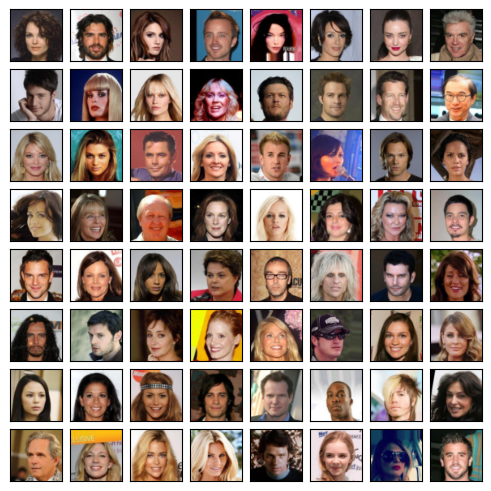

In [13]:
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")

for row in range(8):
    for col in range(8):
        orgs = data.reverse_transform(xs[row * 8 + col].detach().cpu()).transpose(0, -1)
        axes[row, col].imshow(orgs)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_orgs.pdf", bbox_inches="tight")
plt.show()

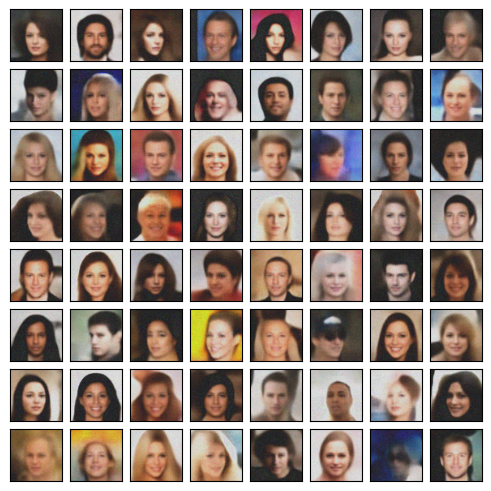

In [14]:
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")

for row in range(8):
    for col in range(8):
        estimates = data.reverse_transform(x_hats[row * 8 + col].detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [15]:
del xs
del x_hats

In [16]:
model.graph.clear()

In [17]:
posterior = {k: torch.cat((v.detach(), model.particles["valid"][k].detach()), dim=1)
             for k, v in model.particles["train"].items()}
x_hats = model.graph.predict(B=64 // model.num_particles, P=model.num_particles, **posterior)
x_hats = torch.flatten(x_hats, 0, 1)

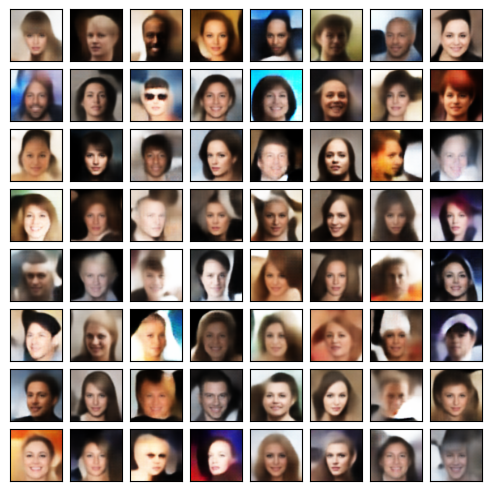

In [18]:
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")

for row in range(8):
    for col in range(8):
        estimates = data.reverse_transform(x_hats[row * 8 + col].squeeze().detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_predictive.pdf", bbox_inches="tight")
plt.show()

In [19]:
del x_hats

In [20]:
model.graph.clear()

In [21]:
model.graph(B=64 // model.num_particles, lr=1e-3, mode="prior", P=model.num_particles)
for _ in range(299):
    model.graph(B=64 // model.num_particles, lr=1e-3, P=model.num_particles)
x_hats = model.graph(B=64 // model.num_particles, lr=1e-3, mode="prior", P=model.num_particles)
x_hats = x_hats.flatten(0, 1)

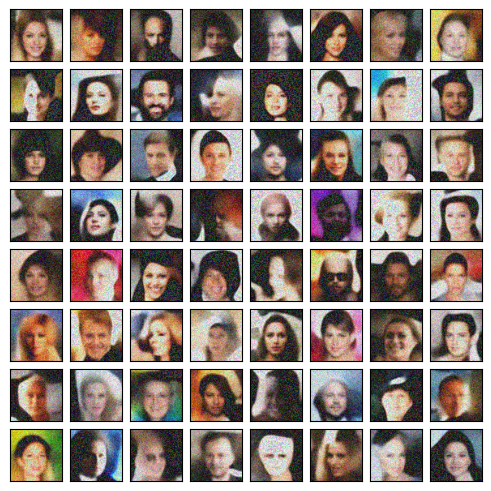

In [22]:
fig, axes = plt.subplots(nrows=8, ncols=8, sharex="all", sharey="all", layout="compressed")

for row in range(8):
    for col in range(8):
        estimates = data.reverse_transform(x_hats[row * 8 + col].squeeze().detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("ppc_celeba_priors.pdf", bbox_inches="tight")
plt.show()

In [23]:
del x_hats

In [24]:
SEEDS = [123, 456, 789, 101112, 131415]

In [25]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [26]:
with torch.no_grad():
    for (s, SEED) in enumerate(SEEDS):
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        for b, (xs, target, indices) in enumerate(data.val_dataloader()):
            xs = xs.to(model.device)
            model._load_particles(indices, False)
            x_hats = model.graph(B=len(xs), mode="prior", P=model.num_particles)
            with model.graph.condition(X=xs) as predictive:
                trace, _ = predictive(B=len(xs), P=model.num_particles)
            LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum().cpu()
            MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean().cpu()
    
            del xs
            del x_hats
            del trace
            del target
            del indices
            logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))
    
        LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset)
        MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0
Evaluated likelihood for valid batch 5 under seed 0
Evaluated likelihood for valid batch 6 under seed 0
Evaluated likelihood for valid batch 7 under seed 0
Evaluated likelihood for valid batch 8 under seed 0
Evaluated likelihood for valid batch 9 under seed 0
Evaluated likelihood for valid batch 10 under seed 0
Evaluated likelihood for valid batch 11 under seed 0
Evaluated likelihood for valid batch 12 under seed 0
Evaluated likelihood for valid batch 13 under seed 0
Evaluated likelihood for valid batch 14 under seed 0
Evaluated likelihood for valid batch 15 under seed 0
Evaluated likelihood for valid batch 16 under seed 0
Evaluated likelihood for valid batch 17 under seed 0
Evaluated likelihood for valid batch 18 under seed 0
Eva

In [27]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-1476779.7500), tensor(1872.7255))

In [28]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.1417), tensor(4.7767e-05))

In [29]:
model.graph.clear()

In [30]:
model.graph.likelihood.scale

tensor(0.1773, device='cuda:7')

In [31]:
fids = []
metrics = collections.defaultdict(lambda: [])
data.setup("test")

for f in range(10):
    for b, batch in enumerate(tqdm.tqdm(data.test_dataloader(), desc='Test set FIDs')):
        ms = model.test_step(batch, b)
        for k, v in ms.items():
            metrics[k].append(v)
    fids.append(model.metrics['fid'].compute())
    model.metrics['fid'].reset()
    model.graph.gmm = None

fids = torch.stack(fids, dim=0)
fids.mean(), fids.std()

Files already downloaded and verified


Test set FIDs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [07:11<00:00,  1.38s/it]


(tensor(79.0209), tensor(0.9274))

In [32]:
for k, v in metrics.items():
    metrics[k] = torch.tensor(v)

In [33]:
{m: v.mean(dim=-1) for m, v in metrics.items()}

{'ess': tensor(15.1619),
 'log_joint': tensor(-59316.5586),
 'log_marginal': tensor(-59382.5273),
 'loss': tensor(59383.7539)}

In [34]:
{m: v.std(dim=-1) for m, v in metrics.items()}

{'ess': tensor(0.3730),
 'log_joint': tensor(805.5913),
 'log_marginal': tensor(804.6796),
 'loss': tensor(804.7018)}